In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 194.34it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.09it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

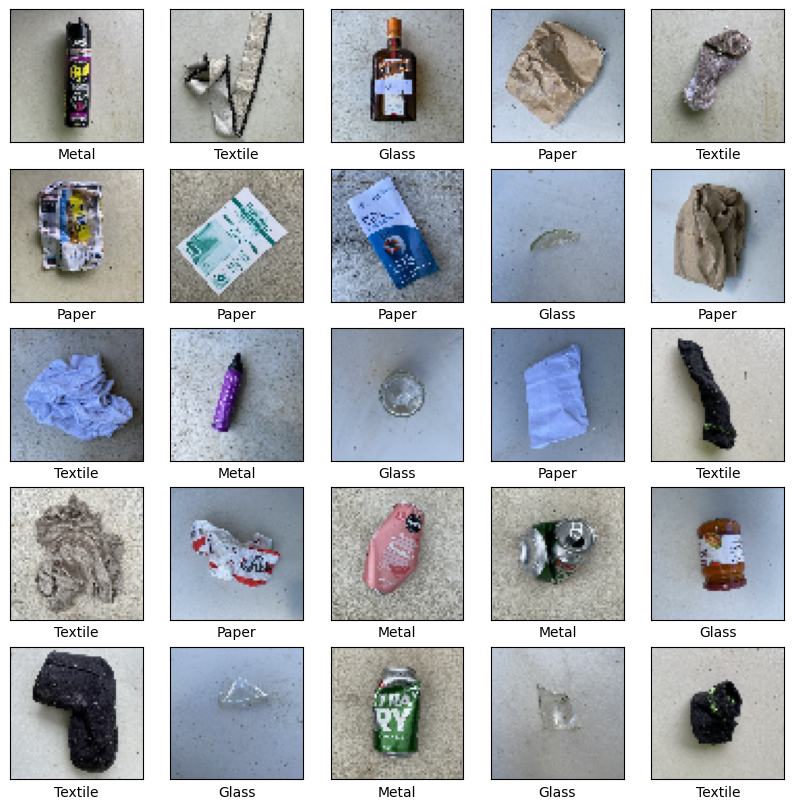

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 10 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')     
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,444 (1.61 MB)

 Trainable params: 421,444 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
        
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')   
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,756 (1.14 MB)

 Trainable params: 298,756 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
            
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,300 (919.14 KB)

 Trainable params: 235,300 (919.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Exponential decay for learning rate

def scheduler(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [18]:
# Set number of epochs

epochs = 100
batch_size = 64


In [19]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback, model_checkpoint_callback1])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)

Time model start: 2024-11-08 11:34:31.247959

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2886 - loss: 1.3901
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2944 - loss: 1.3873 - val_accuracy: 0.4444 - val_loss: 1.3133 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4579 - loss: 1.2435
Epoch 2: val_accuracy improved from 0.44444 to 0.49074, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4573 - loss: 1.2386 - val_accuracy: 0.4907 - val_loss: 1.1258 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0


Epoch 19: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 19/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7813 - loss: 0.5716
Epoch 19: val_accuracy improved from 0.68056 to 0.69907, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7823 - loss: 0.5698 - val_accuracy: 0.6991 - val_loss: 0.6962 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7510 - loss: 0.5785
Epoch 20: val_accuracy improved from 0.69907 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7550 - loss: 0.5726 - val_accuracy: 0.7222 - val_loss: 0.7009 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7989 - l

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9055 - loss: 0.2672
Epoch 37: val_accuracy did not improve from 0.74537
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9037 - loss: 0.2693 - val_accuracy: 0.7130 - val_loss: 0.7131 - learning_rate: 9.8000e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 38/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8918 - loss: 0.2844
Epoch 38: val_accuracy did not improve from 0.74537
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8939 - loss: 0.2821 - val_accuracy: 0.7454 - val_loss: 0.6621 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9059 - loss: 0.2529
Epoch 39: val_accuracy improved from 0.74537 to 0.75926, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9066 - loss: 0.2521 - val_accuracy


Epoch 56: LearningRateScheduler setting learning rate to 0.0005867622356163337.
Epoch 56/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9685 - loss: 0.1065
Epoch 56: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9690 - loss: 0.1075 - val_accuracy: 0.7639 - val_loss: 0.7134 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9729 - loss: 0.1482
Epoch 57: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9732 - loss: 0.1425 - val_accuracy: 0.7731 - val_loss: 0.7194 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9630 - loss: 0.1151
Epoch 58: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9905 - loss: 0.0634
Epoch 75: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9890 - loss: 0.0643 - val_accuracy: 0.7778 - val_loss: 0.7609 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9799 - loss: 0.0759
Epoch 76: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9793 - loss: 0.0760 - val_accuracy: 0.7685 - val_loss: 0.7273 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9859 - loss: 0.0822
Epoch 77: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accurac


Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9821 - loss: 0.0673
Epoch 94: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9824 - loss: 0.0668 - val_accuracy: 0.7731 - val_loss: 0.7724 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9896 - loss: 0.0531
Epoch 95: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9896 - loss: 0.0533 - val_accuracy: 0.7824 - val_loss: 0.7752 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9859 - loss: 0.0560
Epoch 96: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 

In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)

Time model start: 2024-11-08 11:35:19.931235

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2350 - loss: 1.4464
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.2353 - loss: 1.4443 - val_accuracy: 0.2639 - val_loss: 1.3837 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2682 - loss: 1.3812
Epoch 2: val_accuracy improved from 0.26389 to 0.42593, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.2702 - loss: 1.3806 - val_accuracy: 0.4259 - val_loss: 1.3516 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7586 - loss: 0.6009 - val_accuracy: 0.7130 - val_loss: 0.7293 - learning_rate: 9.8000e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7820 - loss: 0.5704
Epoch 19: val_accuracy improved from 0.71296 to 0.73148, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.7811 - loss: 0.5704 - val_accuracy: 0.7315 - val_loss: 0.6757 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7803 - loss: 0.5070
Epoch 20: val_accuracy did not improve from 0.73148
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7805 - loss: 0.5070 - val_accuracy: 0.7315 - val_loss: 0.6666 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00098


Epoch 37: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 37/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9218 - loss: 0.2081
Epoch 37: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9205 - loss: 0.2106 - val_accuracy: 0.7361 - val_loss: 0.7216 - learning_rate: 9.8000e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9108 - loss: 0.2634
Epoch 38: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9113 - loss: 0.2620 - val_accuracy: 0.7639 - val_loss: 0.6778 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9072 - loss: 0.2166
Epoch 39: val_accuracy did not improve from 0.79167
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accu


Epoch 56: LearningRateScheduler setting learning rate to 0.0005867622356163337.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9803 - loss: 0.0540
Epoch 56: val_accuracy improved from 0.80556 to 0.81019, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9802 - loss: 0.0543 - val_accuracy: 0.8102 - val_loss: 0.6200 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9901 - loss: 0.0403
Epoch 57: val_accuracy did not improve from 0.81019
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9901 - loss: 0.0404 - val_accuracy: 0.7870 - val_loss: 0.6826 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9833 - loss: 0.0508
Epoch 58: val_accuracy did not improve fro


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9937 - loss: 0.0257
Epoch 75: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9933 - loss: 0.0263 - val_accuracy: 0.8102 - val_loss: 0.6755 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9933 - loss: 0.0219
Epoch 76: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9933 - loss: 0.0219 - val_accuracy: 0.8148 - val_loss: 0.6244 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9889 - loss: 0.0316
Epoch 77: val_accuracy did not improve from 0.81481
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - a


Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9969 - loss: 0.0159
Epoch 94: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9968 - loss: 0.0161 - val_accuracy: 0.8102 - val_loss: 0.6601 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9979 - loss: 0.0120
Epoch 95: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9978 - loss: 0.0121 - val_accuracy: 0.8056 - val_loss: 0.6707 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9948 - loss: 0.0160
Epoch 96: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accu

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback3])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-08 11:38:58.118867

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2194 - loss: 1.4163
Epoch 1: val_accuracy improved from -inf to 0.31944, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.2205 - loss: 1.4155 - val_accuracy: 0.3194 - val_loss: 1.3853 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2314 - loss: 1.3874
Epoch 2: val_accuracy did not improve from 0.31944
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.2332 - loss: 1.3872 - val_accuracy: 0.2315 - val_loss: 1.3849 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2501 - loss: 1.3881
Epoch 3


Epoch 19: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6951 - loss: 0.7521
Epoch 19: val_accuracy improved from 0.63889 to 0.68519, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.6952 - loss: 0.7513 - val_accuracy: 0.6852 - val_loss: 0.7458 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7288 - loss: 0.6791
Epoch 20: val_accuracy improved from 0.68519 to 0.72685, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.7291 - loss: 0.6789 - val_accuracy: 0.7269 - val_loss: 0.7154 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.762

Epoch 37/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8950 - loss: 0.3089
Epoch 37: val_accuracy improved from 0.79630 to 0.80556, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.8955 - loss: 0.3077 - val_accuracy: 0.8056 - val_loss: 0.5617 - learning_rate: 9.8000e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9070 - loss: 0.2547
Epoch 38: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9062 - loss: 0.2559 - val_accuracy: 0.7685 - val_loss: 0.6381 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9319 - loss: 0.1896
Epoch 39: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9306 - loss: 0.


Epoch 56: LearningRateScheduler setting learning rate to 0.0005867622356163337.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9638 - loss: 0.1132
Epoch 56: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9639 - loss: 0.1127 - val_accuracy: 0.8102 - val_loss: 0.6398 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9700 - loss: 0.0826
Epoch 57: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9701 - loss: 0.0823 - val_accuracy: 0.8148 - val_loss: 0.7387 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9790 - loss: 0.0551
Epoch 58: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accur


Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9891 - loss: 0.0314
Epoch 75: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9891 - loss: 0.0313 - val_accuracy: 0.8241 - val_loss: 0.7300 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9963 - loss: 0.0261
Epoch 76: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9962 - loss: 0.0262 - val_accuracy: 0.8102 - val_loss: 0.7937 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9880 - loss: 0.0348
Epoch 77: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - a


Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9911 - loss: 0.0214
Epoch 94: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9910 - loss: 0.0216 - val_accuracy: 0.8148 - val_loss: 0.8011 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9998 - loss: 0.0112
Epoch 95: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9998 - loss: 0.0112 - val_accuracy: 0.8148 - val_loss: 0.8336 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9903 - loss: 0.0185
Epoch 96: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accu

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:2.3)')

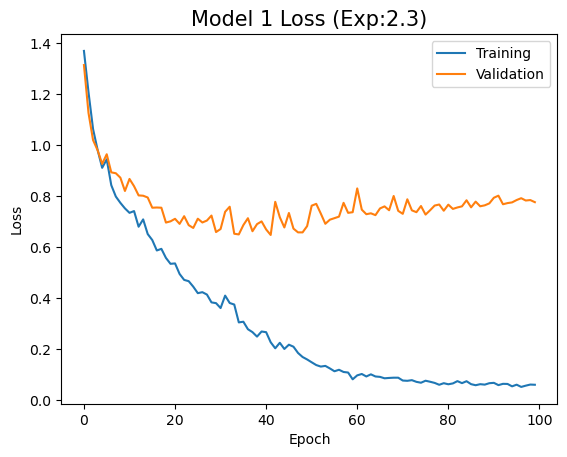

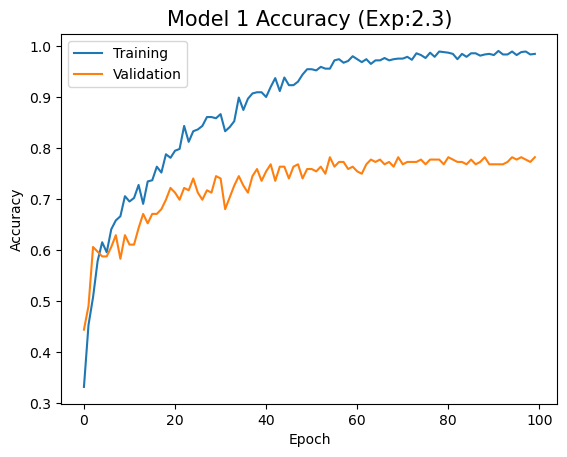

In [22]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:2.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:2.3)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:2.3)')

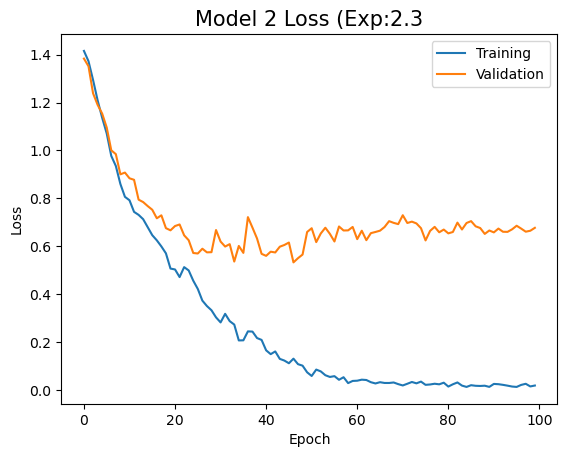

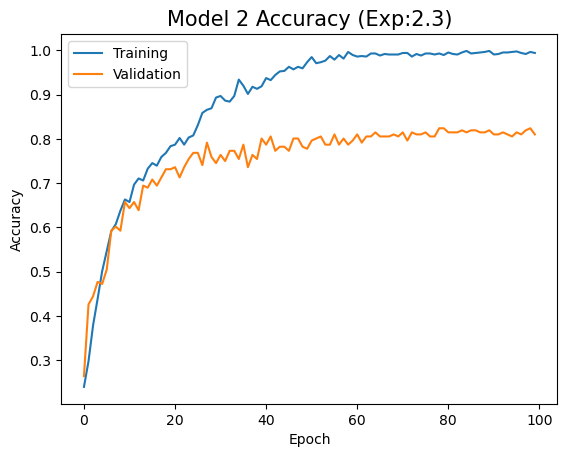

In [23]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:2.3', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:2.3)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:2.3)')

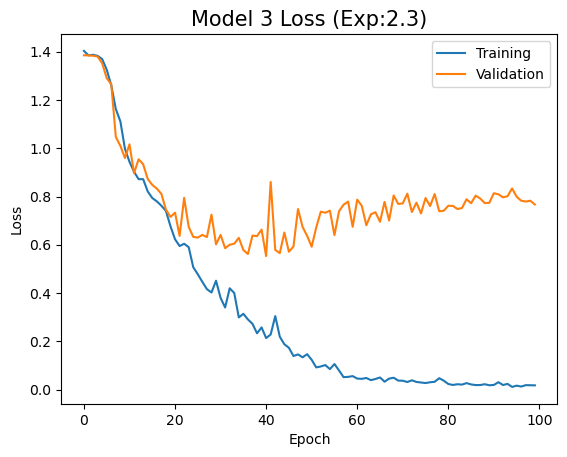

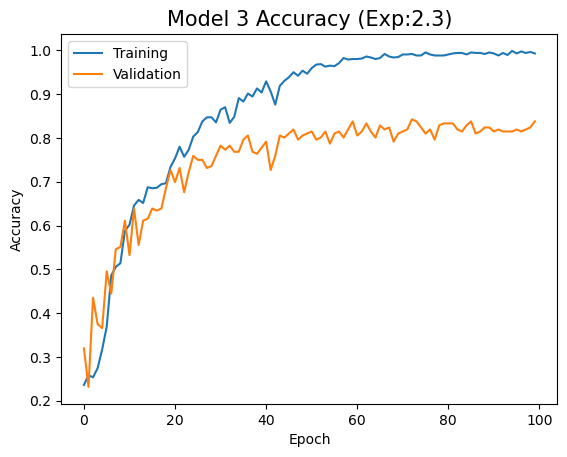

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:2.3)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:2.3)', fontsize = 15)

In [25]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7434 - loss: 0.8579 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8430 - loss: 0.6375
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8514 - loss: 0.5847


In [26]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [27]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [28]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


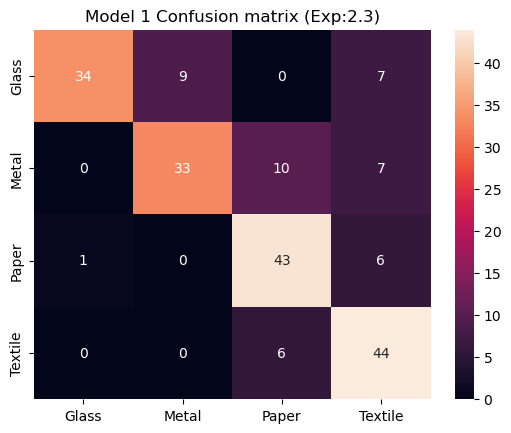

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:2.3)')
plt.show()

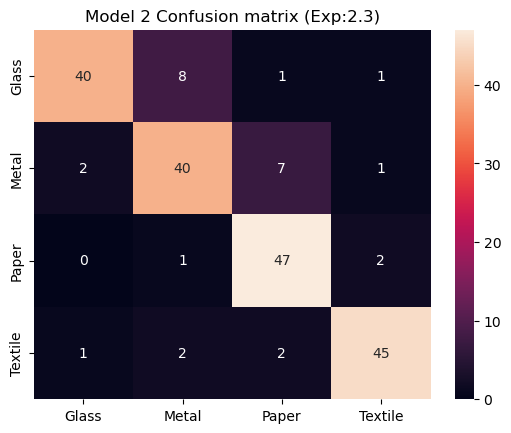

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:2.3)')
plt.show()


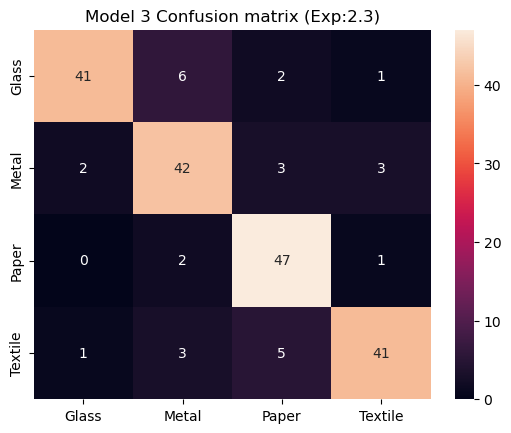

In [31]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:2.3)')
plt.show()